In [1]:
# Importing necessary packages, and classes adapted from decision boundary visualization studies

import numpy as np
import os
import torch
from torchvision import datasets, transforms

import Models

In [2]:
# Importing MNIST dataset from ../data folder
data_dir = os.path.abspath(os.path.join(os.getcwd(), "../data"))
MNIST_data = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())

In [3]:
# Importing the MNIST classifier model
model_name = "small_conv_vanilla"
model_dir = os.path.abspath(os.path.join(os.getcwd(), "../models", model_name + ".pth"))

MNIST_classifier = Models.SmallConvNet()
MNIST_classifier.load_state_dict(torch.load(model_dir))
device_torch = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else 
                      "cpu")
MNIST_classifier.to(device_torch)

SmallConvNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=49, bias=True)
  (fc2): Linear(in_features=49, out_features=10, bias=True)
)

In [4]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), "../models/ssnp"))
ssnp_name = "ssnp_mnist"
ssnp_path_and_name = os.path.join(save_dir, ssnp_name)


  1/313 ━━━━━━━━━━━━━━━━━━━━ 1:27 280ms/step

c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


c:\Users\clavo\miniconda3\envs\OPTML_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['main_input']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
10000
100
Saving vanilla. 300x300 - MNIST - small_conv_vanilla
Saving alpha. 300x300 - MNIST - small_conv_vanilla
Saving hsv. 300x300 - MNIST - small_conv_vanilla


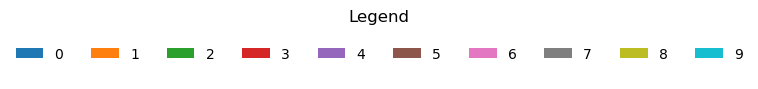

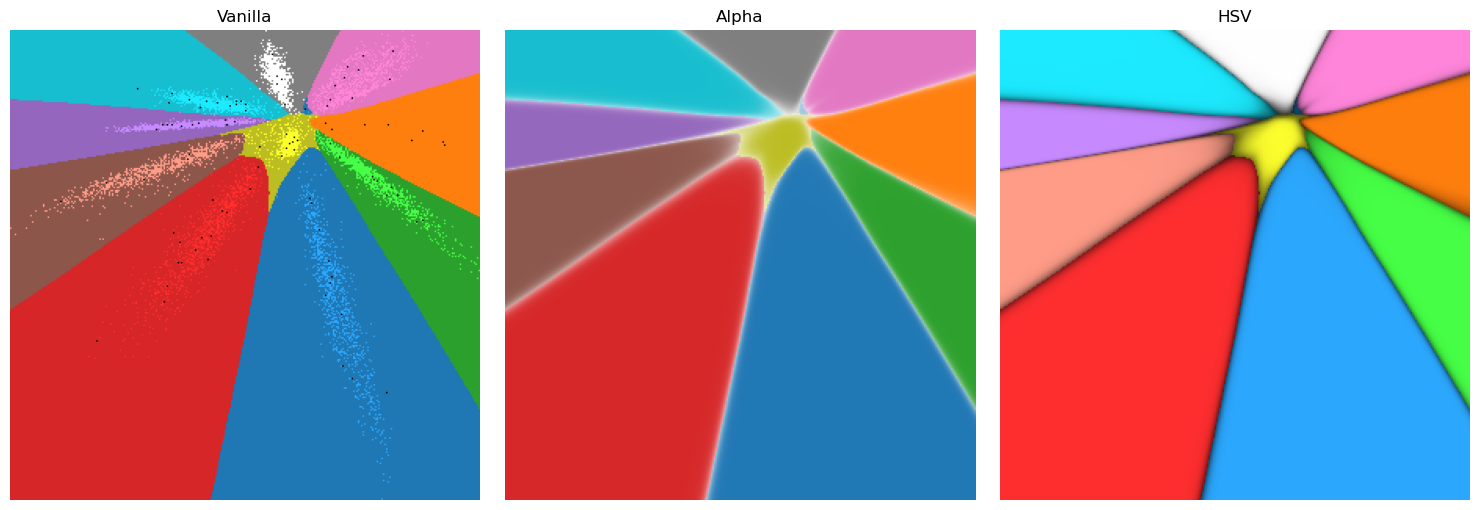

In [5]:
# Calling data visualization
from ssnp import visualize_decision_boundaries

### GENERATE SYNTHETIC ADVERSARIAL EXAMPLES BY JUST RANDOMLY CHOOSING MNIST DATA AND CALLING IT "ADVERSARIAL" ###

# extract x data from mnist and send to torch tensor
adversarial_data = MNIST_data.data.view(-1, 28, 28).float()
# sample 100 examples from the batch of adverarial data randomly
adversarial_data = adversarial_data[torch.randint(0, adversarial_data.shape[0], (100,))]

# function to call to produce visualisation
ssnp, im_grid, prob_grid = visualize_decision_boundaries(
    original_dataset = MNIST_data,
    dataset_name = "MNIST",
    classifier_model = MNIST_classifier,
    classifier_model_name = model_name,
    ssnp_path_and_name = ssnp_path_and_name,
    adversarial_images=adversarial_data,
    verbose = True,
)

In [6]:
adversarial_data.shape

torch.Size([100, 28, 28])